# CNN with data augmentation, 3 layers - batch compensation - dropout in the last layer - p = 0.5 epoch 20



# Import libraries

import libraries including:
- modules for data loading (DataLoader)
- neural networks (nn)
- optimization (optim)
- datasets (datasets)
- data transformations (transforms)
- visualization (plt)
- besides, functional module of PyTorch (F) for certain functions like activation functions.

In [2]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Data tranformation

The code defines two sets of data transformations:
    
- train_transform: For training data, it includes random resized cropping, random horizontal flipping, transforming to tensors, and normalization.
- test_transform: For test data, it includes transforming to tensors and normalization.

In [3]:
# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Data loading

The code loads the CIFAR100 dataset using the defined data transformations.
For training, it uses the train_transform with data augmentation, and for testing, it uses the test_transform.

In [4]:
# Load the CIFAR100 dataset with data augmentation for training
train_dataset = datasets.CIFAR100(
    root='data',
    train=True,
    transform=train_transform,
    download=True
)

# Load the CIFAR100 dataset for testing without data augmentation
test_dataset = datasets.CIFAR100(
    root='data',
    train=False,
    transform=test_transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


# Model and Training Parameters:

Hyperparameters are set, including batch_size, learning_rate, and num_epochs.
input_size is inferred as the flattened size of the image.

The architecture for the CNN model is defined using a class named CNN.

The model consists of convolutional layers, batch normalization layers, ReLU activation functions, max-pooling layers, and fully connected layers.

The last fully connected layer has dropout and uses the softmax function for classification.

The defined CNN model is instantiated as model.

The cross-entropy loss function (nn.CrossEntropyLoss()) is used for the classification task.

The Adam optimizer is used to optimize the model parameters.

train_loader and test_loader are defined using DataLoader with the specified batch sizes.

Shuffle is set to True for the training loader to shuffle the data during training.

In [5]:
# Set the model and training parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# Define the CNN model with Batch Normalization and Dropout on the last layer
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 128, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 100)
        self.dropout3 = nn.Dropout(p=0.3)  # Dropout on the last layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.dropout3(x)  # Apply dropout on the last layer
        x = F.log_softmax(x, dim=1)
        return x

# Instantiate the CNN model with Batch Normalization and Dropout
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load the data using DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluation Function (evaluate):

This function evaluates the model's performance on the given data loader.
It sets the model to evaluation mode using model.eval().
For each batch, it computes the loss, accuracy, and average loss, without performing backpropagation

Training Function (train):
This function trains the model using the provided data loader and optimization parameters.

It sets the model to training mode using model.train().
For each batch, it performs a forward pass, computes the loss, performs backpropagation, and updates the model parameters using the optimizer.

Training Loop:
The code iterates over the specified number of epochs.
For each epoch, it trains the model using the train function and evaluates it using the evaluate function.

It records training and testing loss as well as training and testing accuracy.

In [6]:
# Define the evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

# Define the training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

# Train the model
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%')



Epoch [1/20], Train Loss: 3.63, Train Accuracy: 19.06%, Test Loss: 2.78, Test Accuracy: 32.55%
Epoch [2/20], Train Loss: 3.16, Train Accuracy: 28.52%, Test Loss: 2.54, Test Accuracy: 38.19%
Epoch [3/20], Train Loss: 2.97, Train Accuracy: 32.68%, Test Loss: 2.39, Test Accuracy: 40.55%
Epoch [4/20], Train Loss: 2.85, Train Accuracy: 35.31%, Test Loss: 2.23, Test Accuracy: 43.92%
Epoch [5/20], Train Loss: 2.73, Train Accuracy: 37.61%, Test Loss: 2.17, Test Accuracy: 45.15%
Epoch [6/20], Train Loss: 2.63, Train Accuracy: 40.18%, Test Loss: 2.11, Test Accuracy: 47.23%
Epoch [7/20], Train Loss: 2.54, Train Accuracy: 41.85%, Test Loss: 2.03, Test Accuracy: 48.74%
Epoch [8/20], Train Loss: 2.46, Train Accuracy: 43.77%, Test Loss: 2.03, Test Accuracy: 48.05%
Epoch [9/20], Train Loss: 2.39, Train Accuracy: 45.22%, Test Loss: 1.94, Test Accuracy: 49.95%
Epoch [10/20], Train Loss: 2.31, Train Accuracy: 47.14%, Test Loss: 1.97, Test Accuracy: 49.32%
Epoch [11/20], Train Loss: 2.25, Train Accuracy: 

# Performance Plotting:

After training is complete, the code generates two plots.
The first plot displays the training and testing loss over the epochs.
The second plot displays the training and testing accuracy over the epochs.

The code uses plt to visualize the performance curves, including losses and accuracies.

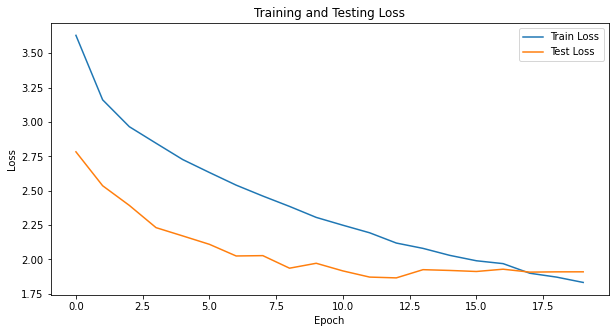

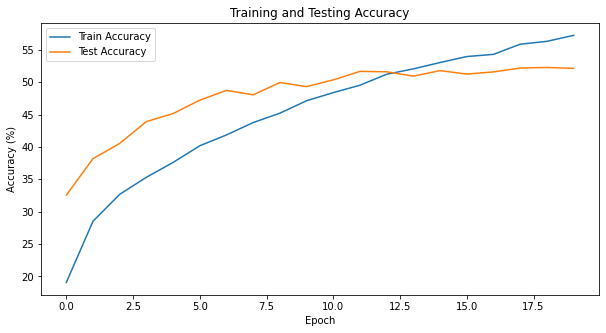

In [7]:



# Plotting performance curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()




# Result:

Comparing with the simple CNN, by introducing more layer, data augmentation, and drop out in the last layer, we corrected greatly the overfitting and increased the global result (57% train vs 52% test)

The last fully connected layer in a CNN often serves as a classifier, mapping the learned features from the previous layers to class probabilities. Dropout helps to prevent overfitting by reducing the risk of the model memorizing the training data and fitting noise. By randomly dropping out neurons, the model becomes less sensitive to specific training samples, leading to better generalization to unseen data. Thus, it helps to prevent co-adaptation and enhances robutness of the model.

The loss curve decreased to get convergence around 2% for both train and test. This value should represent the minimum loss achievable by the model given the data and architecture. 
The little improvement in the test loss plateau, might indicate that the model has reached its capacity or that the learning rate needs adjustment. 